# Key Findings from Titanic Survival Analysis

This exploratory data analysis investigates the factors that influenced passenger survival rates during the Titanic disaster. Our statistical analysis reveals:

- **Passenger Class (Fare)**: The strongest predictor of survival with extremely high statistical significance (p < 10^-12)
- **Gender**: Women had significantly higher survival rates than men among adults
- **Boarding Location**: Where passengers embarked showed a statistically significant association with survival
- **Age**: While children had higher survival rates, age was not a significant predictor among adults

The following notebook walks through the statistical tests, visualizations, and analysis that support these findings.

# The Classical Titanic Dataset

Let's get to work

In [1]:
import pandas as pd

url = 'titanic.csv'
# ok works

df = pd.read_csv(url)
# df.head()

# print("Some statistics about missing values in the original, uncleaned dataset:\n", df.isna().sum())

# print("\n\nDropping rows with missing 'Survived' column...")

df = df.dropna(subset=['Survived'])

# print(df.isna().sum())

print("We have data about", df.shape[0], "passengers and", df.shape[1], "features.")

print("Let's see if boarding location (Embarked) had an impact on survival rate.")

surv_by_emb_loc = df.groupby('Embarked')['Survived'].mean()

print("There are three groups: \n\
C:\t Cherbourg \n\
Q:\t Queenstown \n\
S:\t Southampton \n\
These are the locations where passengers boarded the Titanic. \
Below are the survival rates.\n")

print(surv_by_emb_loc)

print("There *seems* to be some difference in survival rates based on boarding location.")
print("Lets do some p-value testing to see if this is statistically significant.")

We have data about 891 passengers and 21 features.
Let's see if boarding location (Embarked) had an impact on survival rate.
There are three groups: 
C:	 Cherbourg 
Q:	 Queenstown 
S:	 Southampton 
These are the locations where passengers boarded the Titanic. Below are the survival rates.

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64
There *seems* to be some difference in survival rates based on boarding location.
Lets do some p-value testing to see if this is statistically significant.


# Embarked Location Vs. Survival Rate

Does the port of entry affect the chances of survival?

In [ ]:
from IPython.display import display, Math, Markdown
import pandas as pd
import math

display(Markdown("The null hypothesis, $H_0$, is that survival rates are independent of boarding location."))

print("Let's see the p-value of seeing the outcome we did given the null hypothesis is true.")

# Create the contingency table
contingency_table = pd.crosstab(df['Embarked'], df['Survived'])

# Rename columns
contingency_table.rename(columns={0: 'Did Not Survive', 1: 'Survived'}, inplace=True)

# Add total column
contingency_table['Total'] = contingency_table.sum(axis=1)

# Display as Markdown table
header = ['Embarked'] + [str(col) for col in contingency_table.columns]
rows = [contingency_table.index.astype(str).tolist()] + [
    contingency_table[col].tolist() for col in contingency_table.columns
]
table_md = "| " + " | ".join(header) + " |\n"
table_md += "|---" * len(header) + "|\n"
for i in range(len(contingency_table)):
    table_md += "| " + " | ".join(str(rows[j][i]) for j in range(len(rows))) + " |\n"
display(Markdown(table_md))

print("Starting Chi-Squared test..")

display(Markdown("The formula for Chi-Squared is:"))
display(Math(r"\chi^2 = \sum \frac{(O - E)^2}{E}"))

display(Markdown("Let's make the table for Expected values, $E$, based on the null hypothesis. Then, we can calculate the Chi-Squared statistic."))

# Number of Survivors / Total Number of People
survival_rate = df['Survived'].mean()

# Make expected table
expected_table = contingency_table.copy()
expected_table['Survived'] = (contingency_table['Total'] * survival_rate).round(2)
expected_table['Did Not Survive'] = (contingency_table['Total'] * (1 - survival_rate)).round(2)
expected_table = expected_table.drop(columns=['Total'])
expected_table = expected_table[['Did Not Survive', 'Survived']]

# Display expected table as Markdown
header = ['Embarked'] + [str(col) for col in expected_table.columns]
rows = [expected_table.index.astype(str).tolist()] + [
    expected_table[col].tolist() for col in expected_table.columns
]
table_md = "| " + " | ".join(header) + " |\n"
table_md += "|---" * len(header) + "|\n"
for i in range(len(expected_table)):
    table_md += "| " + " | ".join(str(rows[j][i]) for j in range(len(rows))) + " |\n"
display(Markdown("The expected values table is:"))
display(Markdown(table_md))

print("Now let's find the chi-squared value.")
print("Note that finding the chi-squared value is just the same as")
print(f"finding the observed variance divided by the expected variance.")

chi_sqr = 0

for loc in contingency_table.index:
    for outcome in ['Did Not Survive', 'Survived']:
        O = contingency_table.loc[loc, outcome]
        E = expected_table.loc[loc, outcome]
        chi_sqr += (O - E) ** 2 / E

display(Markdown(f"The Chi-Squared statistic is: $\\chi^2 = {chi_sqr:.2f}$"))

# Degrees of freedom
r = 2       # number of rows
c = 2       # number of columns
d_f = (r-1)*(c-1)

# Can use seaborn's function but wanted to implement from scratch.
# Chi-squared PDF formula:
# f(x; k) = (1 / (2^(k/2) * Gamma(k/2))) * x^(k/2 - 1) * exp(-x/2)
# where k = degrees of freedom, x > 0

# Right-tail p-value formula:
# p = integral from chi_sqr to infinity of f(x; df) dx
# This is the probability of observing a chi-squared value at least as large as chi_sqr

# Implement the gamma function via math.gamma
def chi_squared_pdf(x, k):
    return (1 / (2**(k/2) * math.gamma(k/2))) * x**(k/2 - 1) * math.exp(-x/2)


# Numerical integration (trapezoid rule) from chi_sqr to a large number
# Did by hand for 'fun'
upper_limit = chi_sqr*10  # sufficiently far right
steps = 100000
dx = (upper_limit - chi_sqr) / steps
p_value = 0
for i in range(steps):
    x0 = chi_sqr + i*dx
    x1 = chi_sqr + (i+1)*dx
    p_value += (chi_squared_pdf(x0, d_f) + chi_squared_pdf(x1, d_f)) / 2 * dx

mantissa, exponent = f"{p_value:.6e}".split("e")
exponent = int(exponent)
print("Estimated p-value:")
display(Markdown(f'$p = {mantissa} \\times 10^{{{exponent}}}$'))

threshold = 0.05

if p_value < threshold:
    print(f"Since p-value < {threshold}, we reject the null hypothesis.")
    print("There is a statistically significant association between boarding location and survival rate.")
else:
    print(f"Since p-value >= {threshold}, we fail to reject the null hypothesis.")
    print("There is no statistically significant association between boarding location and survival rate.")

The null hypothesis, $H_0$, is that survival rates are independent of boarding location.

Let's see the p-value of seeing the outcome we did given the null hypothesis is true.


| Embarked | Did Not Survive | Survived | Total |
|---|---|---|---|
| C | 75 | 93 | 168 |
| Q | 47 | 30 | 77 |
| S | 427 | 217 | 644 |


Starting Chi-Squared test..


The formula for Chi-Squared is:

<IPython.core.display.Math object>

Let's make the table for Expected values, $E$, based on the null hypothesis. Then, we can calculate the Chi-Squared statistic.

The expected values table is:

| Embarked | Did Not Survive | Survived |
|---|---|---|
| C | 103.52 | 64.48 |
| Q | 47.44 | 29.56 |
| S | 396.81 | 247.19 |


Now let's find the chi-squared value.
Note that finding the chi-squared value is just the same as
finding the observed variance divided by the expected variance.


The Chi-Squared statistic is: $\chi^2 = 26.47$

Estimated p-value:


$p = 2.681249 \times 10^{-7}$

Since p-value < 0.05, we reject the null hypothesis.
There is a statistically significant association between boarding location and survival rate.


In [3]:
print("Now, we see that the null hypothesis can be rejected, and so we may conclude that boarding location not having an impact on survival rate is false.")
print("Thus, we can assume the negation of it and say that boarding location has some sort of association with survival rate")

Now, we see that the null hypothesis can be rejected, and so we may conclude that boarding location not having an impact on survival rate is false.
Thus, we can assume the negation of it and say that boarding location has some sort of association with survival rate


# Gender Vs. Survival

Is it true that women and children were given preferential treatment during the evacuation?


In [4]:
import pandas as pd
from IPython.display import display, Math, Markdown
from scipy.stats import chi2

url = 'titanic.csv'
df = pd.read_csv(url)

df = df.dropna(subset=['Survived'])

print("Now let's investigate if women were given preferential treatment during the evacuation.")
print("First, filter out the children to ensure that boys (who were also given preferential treatment because they were children) do not balance out the results.")

df = df[df['Age'] >= 18]

print(f"We have data about {df.shape[0]} adult passengers and {df.shape[1]} features.")
print(f"{df[df['Sex'] == 'male'].shape[0]} male and {df[df['Sex'] == 'female'].shape[0]} female")

print("-----------------------------")
print("-----------------------------")
print("-----------------------------")
print()

print("Now, let's construct the contingency tables.")
print()

# Create the contingency table
contingency_table = pd.crosstab(df['Sex'], df['Survived'])

# Rename columns
contingency_table.rename(columns={0: 'Did Not Survive', 1: 'Survived'}, inplace=True)

# Add total column
contingency_table['Total'] = contingency_table.sum(axis=1)

# Display as Markdown table
header = ['Gender'] + [str(col) for col in contingency_table.columns]
rows = [contingency_table.index.astype(str).tolist()] + [
    contingency_table[col].tolist() for col in contingency_table.columns
]
table_md = "| " + " | ".join(header) + " |\n"
table_md += "|---" * len(header) + "|\n"
for i in range(len(contingency_table)):
    table_md += "| " + " | ".join(str(rows[j][i]) for j in range(len(rows))) + " |\n"
display(Markdown(table_md))

display(Markdown("The null hypothesis, $H_0$, is that survival rates are independent of gender."))
print("The expected table for that would be:")

total = df.shape[0]
total_men = df[df['Sex'] == 'male'].shape[0]
total_women = df[df['Sex'] == 'female'].shape[0]

survival_rate = df['Survived'].mean()

expected_table = contingency_table.copy()

expected_table['Survived'] = (contingency_table['Total'] * survival_rate).round(2)
expected_table['Did Not Survive'] = (contingency_table['Total'] * (1 - survival_rate)).round(2)

# Now print the expected table using the same markdown format as before
expected_table = expected_table.drop(columns=['Total'])
expected_table = expected_table[['Did Not Survive', 'Survived']]

# Display expected table as Markdown

header = ['Gender'] + [str(col) for col in expected_table.columns]
rows = [expected_table.index.astype(str).tolist()] + [
    expected_table[col].tolist() for col in expected_table.columns
]
table_md2 = "| " + " | ".join(header) + " |\n"
table_md2 += "|---" * len(header) + "|\n"
for i in range(len(expected_table)):
    table_md2 += "| " + " | ".join(str(rows[j][i]) for j in range(len(rows))) + " |\n"
display(Markdown(table_md2))

print("Okay, we see the disparity, now let's calculate the Chi-Squared value.")

chi_sqr = 0

for loc in contingency_table.index:
    for outcome in ['Did Not Survive', 'Survived']:
        O = contingency_table.loc[loc, outcome]
        E = expected_table.loc[loc, outcome]
        chi_sqr += (O - E) ** 2 / E

print(f"The Chi-Squared statistic is: χ² = {chi_sqr:.2f}")

# Degrees of freedom
r = 2       # number of rows
c = 2       # number of columns

d_f = (r-1)*(c-1)  # Degrees of Freedom.

p = chi2.sf(chi_sqr, d_f)

mantissa, exponent = f"{p:.2e}".split("e")
exponent = int(exponent)
display(Markdown(f"P-value: $p = {mantissa} \\times 10^{{{exponent}}}$"))

threshold = 0.05
if p < threshold:
    print(f"Since p-value < {threshold}, we reject the null hypothesis.")
    print("There is a statistically significant association between gender and survival.")
else:
    print(f"Since p-value >= {threshold}, we fail to reject the null hypothesis.")
    print("There is no statistically significant association between gender and survival.") 



Now let's investigate if women were given preferential treatment during the evacuation.
First, filter out the children to ensure that boys (who were also given preferential treatment because they were children) do not balance out the results.
We have data about 601 adult passengers and 21 features.
395 male and 206 female
-----------------------------
-----------------------------
-----------------------------

Now, let's construct the contingency tables.



| Gender | Did Not Survive | Survived | Total |
|---|---|---|---|
| female | 47 | 159 | 206 |
| male | 325 | 70 | 395 |


The null hypothesis, $H_0$, is that survival rates are independent of gender.

The expected table for that would be:


| Gender | Did Not Survive | Survived |
|---|---|---|
| female | 127.51 | 78.49 |
| male | 244.49 | 150.51 |


Okay, we see the disparity, now let's calculate the Chi-Squared value.
The Chi-Squared statistic is: χ² = 202.99


P-value: $p = 4.64 \times 10^{-46}$

Since p-value < 0.05, we reject the null hypothesis.
There is a statistically significant association between gender and survival.


# Age Vs. Survival

Now accounting for age

Analyzing 601 passengers...


**Logistic Regression Results:**

Coefficient for Age: 0.0023

P-value for Age: $p = 7.41 \times 10^{-1}$

Since p-value >= 0.05, we fail to reject the null hypothesis.
There is no statistically significant association between Age and Survival.


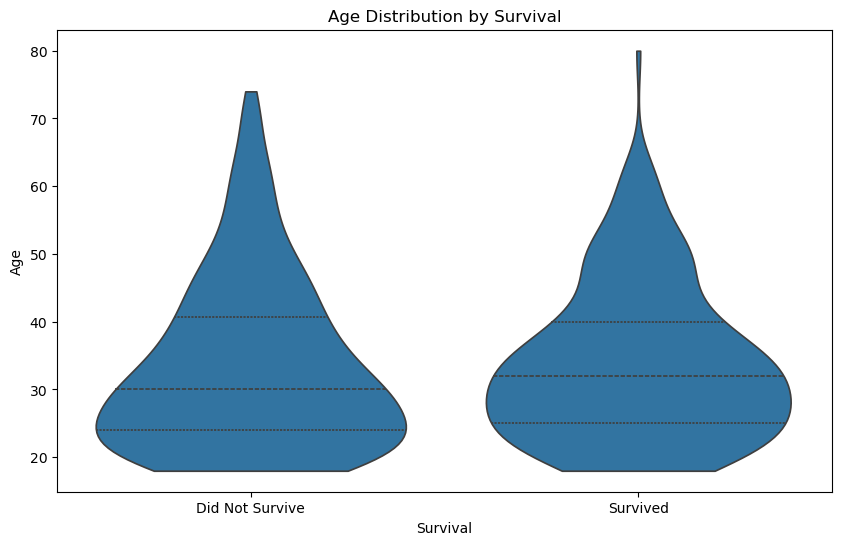

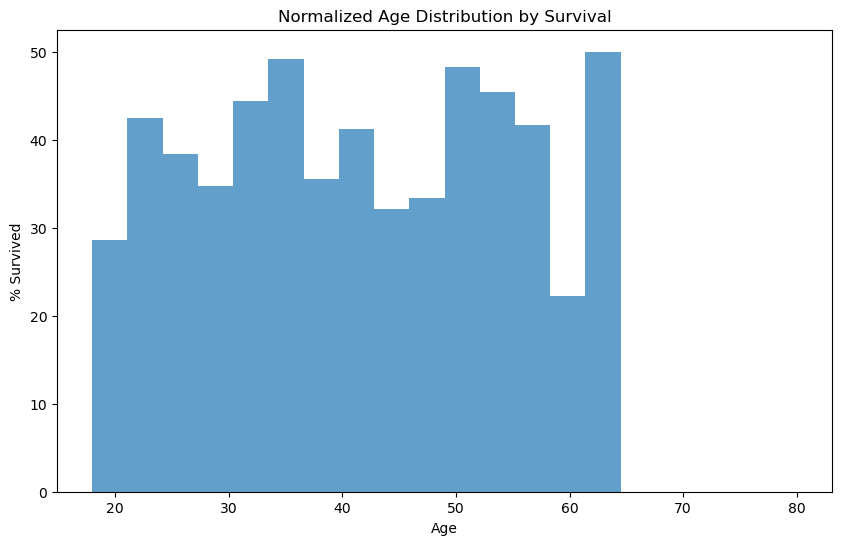

Note: once we take out the >= 18 filter, the p-value becomes larger by about 2 orders of magnitude, indicating that children had a great impact on survival statistics. 
But, once we filter them out, age still has a statistically insignificant (i.e. among adults, age was not a meaningful predictor of survival).


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
import statsmodels.api as sm
import seaborn as sns

# Load data
url = 'titanic.csv'
df = pd.read_csv(url)
df = df.dropna(subset=['Survived', 'Age'])

# Filter adults
df = df[df['Age'] >= 18]

print(f"Analyzing {df.shape[0]} passengers...")

# Logistic regression: Survived ~ Age
X = sm.add_constant(df['Age'])  # add intercept
y = df['Survived']

logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=False)

# Coefficient and p-value
coef_age = result.params['Age']
p_value = result.pvalues['Age']

display(Markdown(f"**Logistic Regression Results:**"))
display(Markdown(f"Coefficient for Age: {coef_age:.4f}"))
mantissa, exponent = f"{p_value:.2e}".split("e")
exponent = int(exponent)
display(Markdown(f"P-value for Age: $p = {mantissa} \\times 10^{{{exponent}}}$"))

threshold = 0.05
if p_value < threshold:
    print(f"Since p-value < {threshold}, we reject the null hypothesis.")
    print("There is a statistically significant association between Age and Survival.")
else:
    print(f"Since p-value >= {threshold}, we fail to reject the null hypothesis.")
    print("There is no statistically significant association between Age and Survival.")

# Violin plot instead of scatter plot
plt.figure(figsize=(10,6))
sns.violinplot(x='Survived', y='Age', data=df, inner='quartile', cut=0)

plt.xticks([0, 1], ['Did Not Survive', 'Survived'])

plt.xlabel("Survival")
plt.ylabel("Age")

plt.title("Age Distribution by Survival")

plt.show()

# Histogram normalized to % survived per bin
bins = 20
bin_edges = np.linspace(df['Age'].min(), df['Age'].max(), bins+1)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

frac_survived = []
for i in range(bins):
    bin_mask = (df['Age'] >= bin_edges[i]) & (df['Age'] < bin_edges[i+1])
    bin_total = bin_mask.sum()
    if bin_total == 0:
        frac_survived.append(0)
    else:
        frac_survived.append(df.loc[bin_mask, 'Survived'].mean()*100)  # percentage

plt.figure(figsize=(10,6))
plt.bar(bin_centers, frac_survived, width=bin_edges[1]-bin_edges[0], alpha=0.7)
plt.xlabel("Age")
plt.ylabel("% Survived")
plt.title("Normalized Age Distribution by Survival")
plt.show()

print("Note: once we take out the >= 18 filter, the p-value becomes larger by about 2 orders of magnitude, indicating that children had a great impact on survival statistics. ")
print("But, once we filter them out, age still has a statistically insignificant (i.e. among adults, age was not a meaningful predictor of survival).")


# Ticket Class Vs. Survival

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
import statsmodels.api as sm
import seaborn as sns

# Load data
url = 'titanic.csv'
df = pd.read_csv(url)
df = df.dropna(subset=['Survived', 'Fare'])  # use Ticket price (Fare)

print(f"Analyzing {df.shape[0]} passengers with fare data...")

# Logistic regression: Survived ~ Fare
X = sm.add_constant(df['Fare'])  # add intercept
y = df['Survived']

logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=False)

# Coefficient and p-value
coef_fare = result.params['Fare']
p_value = result.pvalues['Fare']

display(Markdown(f"**Logistic Regression Results:**"))
display(Markdown(f"Coefficient for Fare: {coef_fare:.4f}"))
mantissa, exponent = f"{p_value:.2e}".split("e")
exponent = int(exponent)
display(Markdown(f"P-value for Fare: $p = {mantissa} \\times 10^{{{exponent}}}$"))

threshold = 0.05
if p_value < threshold:
    print(f"Since p-value < {threshold}, we reject the null hypothesis.")
    print("There is a statistically significant association between Fare and Survival.")
else:
    print(f"Since p-value >= {threshold}, we fail to reject the null hypothesis.")
    print("There is no statistically significant association between Fare and Survival.")

print("So, in conclusion, ticket price by FAR had the greatest impact on surivval, with the p-value being less than one in a trillion (given the null hypothesis)")


Analyzing 891 passengers with fare data...


**Logistic Regression Results:**

Coefficient for Fare: 0.0152

P-value for Fare: $p = 9.86 \times 10^{-12}$

Since p-value < 0.05, we reject the null hypothesis.
There is a statistically significant association between Fare and Survival.
So, in conclusion, ticket price by FAR had the greatest impact on surivval, with the p-value being less than one in a trillion (given the null hypothesis)
